<a href="https://colab.research.google.com/github/deep-diver/image_search_with_natural_language/blob/main/notebooks/Image_Search_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References:
* [Beyond tags and entering the semantic search era on images with OpenAI CLIP](https://towardsdatascience.com/beyond-tags-and-entering-the-semantic-search-era-on-images-with-openai-clip-1f7d629a9978)
* [HuggingFace CLIP Documentation](https://huggingface.co/transformers/model_doc/clip.html)

## Initial setup

In [ ]:
!pip install -q transformers ipyplot==1.1.0 ftfy

     |████████████████████████████████| 71kB 3.8MB/s 


In [ ]:
from io import BytesIO
from PIL import Image
import requests
import ipyplot
 
from transformers import CLIPProcessor, CLIPModel
import torch


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

## Setup search query

In [ ]:
original_api = "https://pixabay.com/api/?key="
pixabay_api_key = "22176616-358d1b190a298ff59f96b35a1"

In [ ]:
#@title Enter the queries
semantic_search_phrase = "Tigers on the snow" #@param {type:"string"}
pixabay_search_keyword = "Tigers" #@param {type:"string"}

In [ ]:
no_to_retrieve = 30
pixabay_api = original_api+pixabay_api_key+"&q="+pixabay_search_keyword.lower()+"&image_type=photo&safesearch=true&per_page="+str(no_to_retrieve)
response = requests.get(pixabay_api)
output = response.json()

all_images =[]
for each in output["hits"]:
    imageurl = each["webformatURL"]
    response = requests.get(imageurl)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    all_images.append(image)

print ("Total no of images retrived: ",len(all_images))


Total no of images retrived:  30



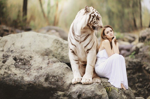
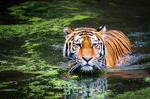
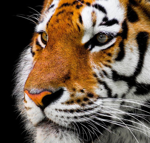
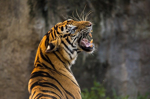
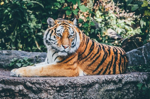
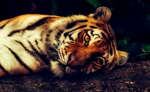
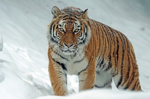
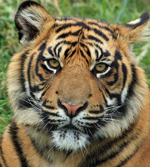
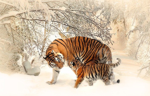
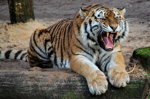
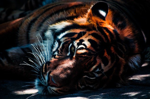
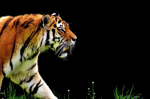
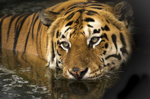
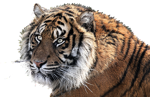
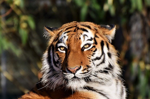
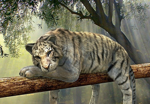
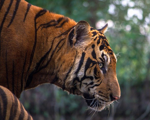
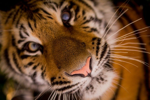
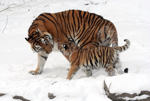
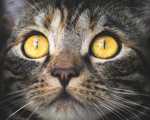
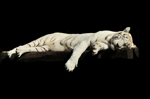
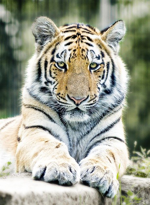
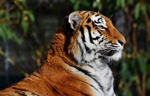
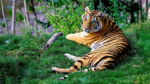
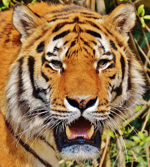
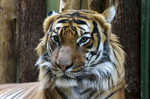
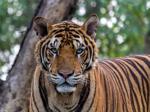
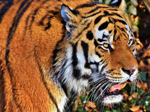
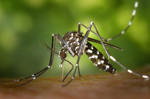
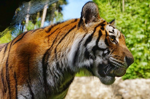


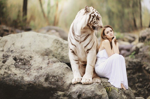
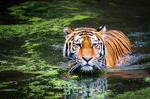
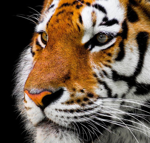
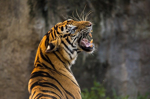
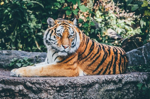
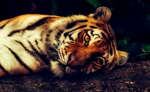
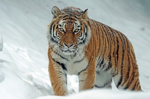
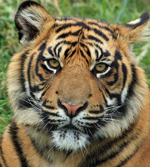
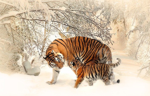
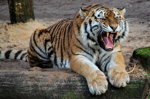
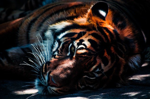
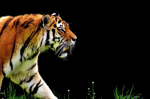
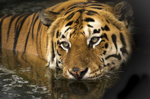
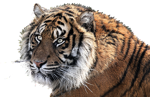
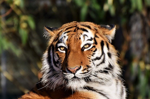
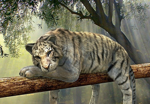
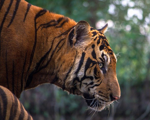
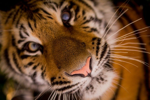
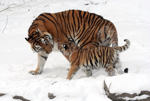
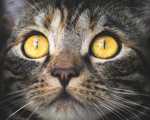
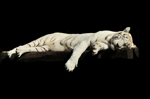
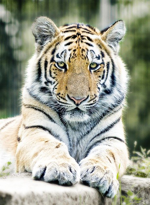
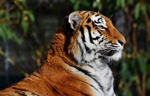
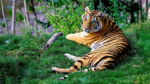
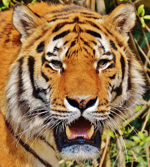
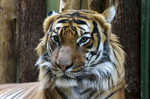
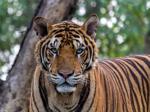
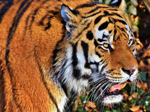
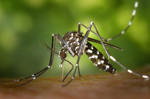
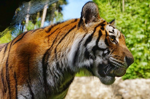

In [ ]:
ipyplot.plot_images(all_images,max_images=50,img_width=150)

## Semantic search with CLIP

In [ ]:
# Obtain the text-image similarity scores
with torch.no_grad():
    inputs = processor(text=[semantic_search_phrase], 
                    images=all_images, return_tensors="pt", padding=True)
    outputs = model(**inputs)

In [ ]:
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

print(logits_per_image.shape, probs.shape)

torch.Size([30, 1]) torch.Size([30, 1])


In [ ]:
# Filter the scores and return indices
values, indices = logits_per_image.squeeze().topk(3) # Top-3

top_images, top_scores = [], []

for score, index in zip(values, indices):
    top_images.append(all_images[int(index.numpy())])
    score = score.numpy().tolist()
    top_scores.append(round(score, 3))

Scores: [34.922, 33.96, 33.094]



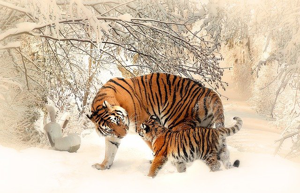
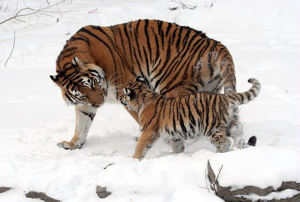
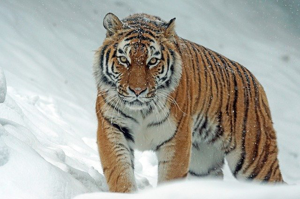


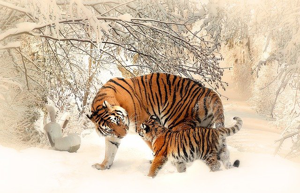
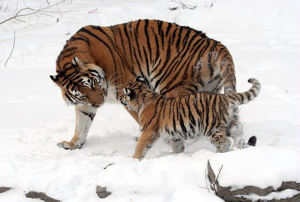
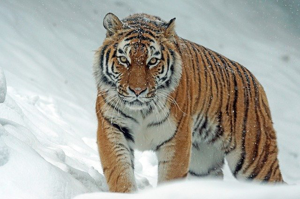

In [ ]:
print (f"Scores: {top_scores}")
ipyplot.plot_images(top_images, img_width=300)